In [1]:
## imports 
# astro
from    astropy.wcs             import WCS
from    astropy.io              import fits
import  astropy.units           as u
from    astropy.nddata          import Cutout2D
from    astropy.coordinates     import SkyCoord
from    astropy.visualization   import (MinMaxInterval, PercentileInterval, ZScaleInterval, SqrtStretch, AsinhStretch, LogStretch, ImageNormalize)
# data 
import  numpy   as np
import  pandas  as pd
# plots
import  matplotlib.pyplot as plt

## file paths 
path_catalogs = 'C:\\Users\\polar\\OneDrive - The University of Kansas\\AGNerds\\Catalogs'

In [2]:
# read file to get agn info
df_agn = pd.read_csv(path_catalogs+'\\AGN_candidates.txt', sep=',')
# display(df_agn)

In [17]:
def getData(fitsFile):
    data = fits.getdata(fitsFile)
    header = fits.getheader(fitsFile)
    f = fits.open(fitsFile)
    wcs = WCS(f[1].header)
    f.close()
    #setting nondetections to nan
    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] == 0:
                data[i][j] = np.nan
    return (data, header, wcs)
    # Credit: Greg T.

In [18]:
# get image data
data_cm1, header_cm1, wcs_cm1 = getData(path_catalogs+'\\ceers_miri1_f1000w_i2d.fits')
print('cm1 DONE')
data_cm2, header_cm2, wcs_cm2 = getData(path_catalogs+'\\ceers_miri2_f1000w_i2d.fits')
print('cm2 DONE')
# data_egs, header_egs, wcs_egs = getData(path_catalogs+'\\egs_all_wfc3_ir_f160w_030mas_v1.9_drz.fits')
# print('egs DONE')

Set DATE-AVG to '2022-06-21T19:01:47.926' from MJD-AVG.
Set DATE-END to '2022-06-21T19:17:17.099' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.743944 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725242515.981 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


cm1 DONE


Set DATE-AVG to '2022-06-21T23:48:57.498' from MJD-AVG.
Set DATE-END to '2022-06-22T00:04:15.579' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.782898 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725446993.656 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


cm2 DONE


In [101]:
def GetCutout(
    ra,     # right ascension [deg]
    dec,    # declination [deg]
    id,     # Candels ID 
    fagn,   # f(AGN)
    wcs,    # World Coordinate System
    data    # image data
):
    # get position on sky 
    coord = SkyCoord(ra*u.degree,dec*u.degree)
    x, y = wcs.world_to_pixel(coord)
    # make cutout 
    dl = 60
    cutout = Cutout2D(data, position=(x,y), size=(dl,dl), wcs=wcs, mode='partial')

    # make figure 
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=cutout.wcs)
    # labels
    ax.set_title('Candels ID = '+str(id)+'. f(AGN) = '+str(fagn))
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    # grid lines
    ax.grid(True, color='r', linestyle='--', linewidth=0.5)
    # mark center coord 
    circle = plt.Circle((dl/2,dl/2), 10, fc=(0,0,0,0), ec="red")
    ax.add_patch(circle)
    # plot image
    norm1 = ImageNormalize(cutout.data, interval=PercentileInterval(99), stretch=AsinhStretch())
    ax.imshow(cutout.data, origin='lower', cmap='gray', norm=norm1)

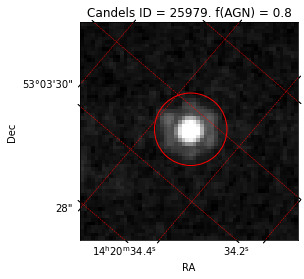

In [102]:
# example source
i = 1
ra  = df_agn.at[i,"RA"]
dec = df_agn.at[i,"Dec"]
id  = df_agn.at[i,"Candels ID"]
fagn = df_agn.at[i,"f(AGN)"]

GetCutout(
    ra,
    dec,
    id,
    fagn,
    wcs_cm1,
    data_cm1
)

# GetCutout( # i must be for miri 2 src
#     ra,
#     dec,
#     id,
#     fagn,
#     wcs_cm2,
#     data_cm2
# )